### Testing VAE on CIFAR-10

In [53]:
using Flux
using BSON
using MLDatasets
using Flux.Optimise: update!, train!
using Flux.Data: DataLoader
using Flux: logitbinarycrossentropy
using ProgressMeter: Progress, next!, ijulia_behavior
ProgressMeter.ijulia_behavior(:clear)

using Plots
using PyPlot

include("util.jl");

In [35]:
using CUDAapi: has_cuda_gpu

# Set GPU
if has_cuda_gpu()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU
└ @ Main In[35]:6


In [36]:
# Experimental parameters
batch_size = 256
input_dim = 32^2*3
hidden_dim = 500
latent_dim = 2
num_epochs = 3
learning_rate = 1e-3
regularization_param = 0.01;

### Data 

In [37]:
# Load data sets
images, labels = CIFAR10.traindata(Float32)

# Vectorize images
X = reshape(images, input_dim, :)

# Start DataLoader
data = DataLoader(X, labels, batchsize=batch_size, shuffle=true);

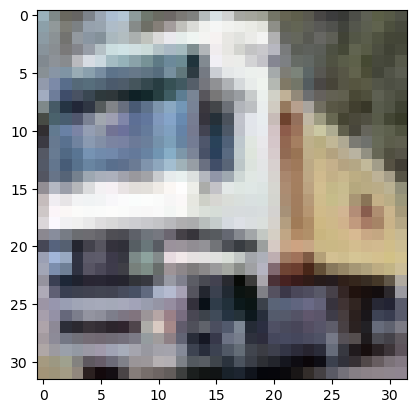

In [42]:
# Visualize example image
PyPlot.imshow(permutedims(images[:,:,:,2], (2,1,3)));

### Network specification

In [43]:
struct Encoder
    "Mapping from input space to hidden space to latent space"
    
    # Pipeline from input space to hidden
    input2hidden
    
    # Pipelines from hidden space to params of Gaussian in latent space
    hidden2μ
    hidden2logσ
    
    Encoder(input_dim, hidden_dim, latent_dim; nonlinearity=tanh, device=cpu) = new(
        Dense(input_dim, hidden_dim, nonlinearity) |> device,   # map2hidden
        Dense(hidden_dim, latent_dim) |> device,                # μ
        Dense(hidden_dim, latent_dim) |> device,                # logσ
    )
end

struct Decoder
    "Mapping from latent space to observed space"
    
    # Pipelines from latent space back to input space
    latent2hidden
    hidden2input
    
    Decoder(latent_dim, hidden_dim, input_dim; nonlinearity=tanh, device=cpu) = new(
        
        # Latent to hidden
        Dense(latent_dim, hidden_dim, nonlinearity) |> device, # latent2hidden

        # Hidden to input
        Dense(hidden_dim, input_dim, nonlinearity) |> device   # hidden2input
    )    
end

function (encoder::Encoder)(x)
    "Apply encoder to input data"

    # Map input to hidden layer
    h = encoder.input2hidden(x)

    # Return mean and log-sigma of encoder
    return encoder.hidden2μ(h), encoder.hidden2logσ(h)
end

function (decoder::Decoder)(z)
   "Apply decoder to sample in latent space" 
    
    # Map samples from latent space to hidden
    h = decoder.latent2hidden(z)
    
    # Map hidden to input space
    return decoder.hidden2input(h)    
end

function reconstruct(x, encoder, decoder; device=cpu)
   "Apply encoder and decoder to data"

    # Encode samples
    μ, logσ = encoder(x)

    # Generate samples in latent space and decode
    z = decoder(μ + device(randn(size(μ))) .* exp.(logσ))
    
    return μ, logσ, z
end

function loss(encoder, decoder, x; regularization_param=0.01, device=cpu)
    "Loss layer"

    # Encode and decode data
    μ, logσ, z = reconstruct(x, encoder, decoder, device=device)

    # KL-divergence
    divergence = 0.5 * sum(@. (exp(2. *logσ) + μ^2 -1. - 2. *logσ))

    # Reconstruction error
    logp_x_z = -sum(logitbinarycrossentropy.(z, x))
    
    # Decoder params
    ps_decoder = Flux.params(decoder.latent2hidden, decoder.hidden2input)

    # regularization
    regularization = regularization_param * sum(x->sum(x.^2), ps_decoder)

    return -logp_x_z + divergence + regularization
end

loss (generic function with 1 method)

### Network training

In [47]:
# Override device set
device = cpu

# Define optimizer
opt = ADAM(learning_rate)

# Define encoder and decoder
enc = Encoder(input_dim, hidden_dim, latent_dim, device=device)
dec = Decoder(latent_dim, hidden_dim, input_dim, device=device)

# Extract parameters
ps = Flux.params(enc.input2hidden, 
                 enc.hidden2μ, 
                 enc.hidden2logσ, 
                 dec.latent2hidden, 
                 dec.hidden2input)

# Create output directory if not present
!ispath("output") && mkpath("output");

In [50]:
@info "Start Training, total $(num_epochs) epochs"
for epoch in 1:num_epochs

    # Report progress
    @info "Epoch $(epoch)"
    progress = Progress(length(data))

    # Iterate over data
    for (x,_) in data

        # Define gradient function
        training_loss, back = Flux.pullback(ps) do
            loss(enc, dec, x |> device, device=device)
        end
        grad = back(1.)

        # Update params
        Flux.Optimise.update!(opt, ps, grad)

        # Update progress meter
        next!(progress; showvalues=[(:loss, training_loss)])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:18
  loss:  159261.88042961917


In [51]:
# Save model
BSON.@save "output/model.bson" enc dec ps

### Results

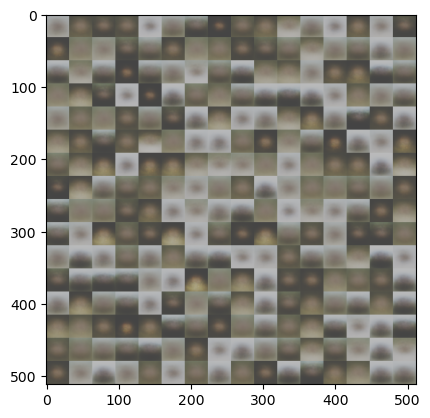

In [94]:
# Take first batch of images and map to image collage
x = first(data)[1]
img_x = convert_to_image(x, 16, rgb=true, patch_size=32)
PyPlot.imshow(img_x, vmin=0.0, vmax=1.0, cmap="gray")
PyPlot.savefig("output/collage_x.png")

# Reconstruct images and map to collage
_, _, z = reconstruct(x, enc, dec)
img_z = convert_to_image(z, 16, rgb=true, patch_size=32)
PyPlot.imshow(img_z, vmin=0.0, vmax=1.0, cmap="gray")
PyPlot.savefig("output/collage_z.png")